<a href="https://colab.research.google.com/github/VincentGaoHJ/Course-CS5242/blob/master/practice_7_handseg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice 7: Hand Segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Data, Dataset and DataLoader

Then we will train our model on a combined dataset comprising of [GTEA](http://cbs.ic.gatech.edu/fpv/) and [Hand over Face (HOF)](https://github.com/aurooj/Hand-Segmentation-in-the-Wild) datasets.

| Stat           | GTEA | HandOverFace |
| :--:           | :--: | :----------: |
| frames         | 663  | 300          |
| hand instances | 1231 | 507          |

In [ ]:
#!wget https://www.comp.nus.edu.sg/~rchen/cs5242/hand_dataset.zip -P /content/drive/MyDrive/data

In [ ]:
import os
import zipfile


# Check whether hand_dataset.zip is unzipped
if not os.path.isdir('/content/drive/MyDrive/data/hand_dataset'):
    with zipfile.ZipFile('/content/drive/MyDrive/data/hand_dataset.zip', 'r') as f:
        f.extractall('/content/drive/MyDrive/data')

The file structure is shown here,

| drive/MyDrive/data

----| hand_dataset

--------| GTEA

------------| Images

------------| Masks

------------| ...

--------| hand_over_face

------------| images_resized

------------| masks

------------| ...

In [ ]:
import glob

import cv2
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm

In [ ]:
GTEA_DSDIR = '/content/drive/MyDrive/data/hand_dataset/GTEA'
HOF_DSDIR = '/content/drive/MyDrive/data/hand_dataset/hand_over_face'

**Visualize one sample and mask in each dataset.**

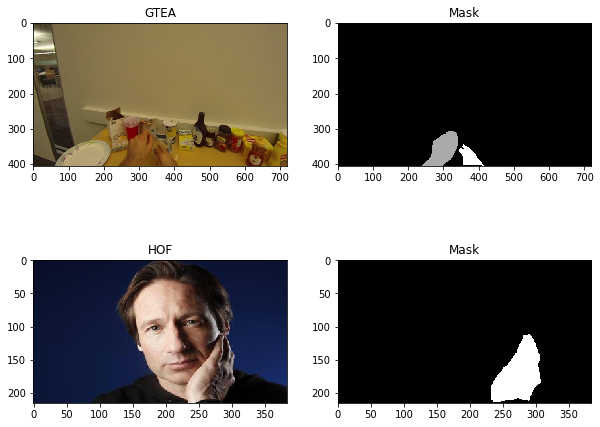

**Customize the segmentation dataset and dataloader. Ref: [PyTorch tutorials](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataset).**

- You can first get the list of image paths and mask paths.

- Split the train and validation dataset according to ratio `9:1`.

- In `__getitem__`, load data from the path using `(PIL.)Image.open`.

- Resize the image into `288 × 384` and normalize with `mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`.

- We only care about hands and background, which means there are 2 classes.

- Use `batch_size = 2`. A small batch size is common in the segmentation task.

In [ ]:
class SegDataset(Dataset):
    
    


















    

In [ ]:
#TTR is Train Test Ratio
def trainTestSplit(dataset, TTR):
    




    return trainDataset, valDataset

### Model

**We use [DeepLabV3](https://arxiv.org/pdf/1706.05587.pdf) model: `models.segmentation.deeplabv3_resnet50`. (#class = 2, hands and background)**

DeepLabV3 = ResNet + DeepLabHead. We use an IN-pretrained ResNet backbone.

![](https://miro.medium.com/max/2400/1*8Lg66z7e7ijuLmSkOzhYvA.png)

In [ ]:
from torchvision import models









DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Then we write a custom model to process the data.

### Metrics

![](https://www.comp.nus.edu.sg/~rchen/cs5242/segmetrics.png)

**HINT:** You may find `logical_and/or` helpful.

In [ ]:
def meanIOU(target, predicted):
    
    









    
    return miou

In [ ]:
def pixelAcc(target, predicted):
   








   
          
    return pixelAccuracy

### Training

**Implement the training loop.**

In [ ]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader, lastCkptPath=None):
    tr_loss_arr = []
    val_loss_arr = []
    meanioutrain = []
    pixelacctrain = []
    meanioutest = []
    pixelacctest = []
    prevEpoch = 0
    
    # Resume the model from the path
    if lastCkptPath != None :
        



    # Training and evaluation


















        
    return tr_loss_arr, val_loss_arr, meanioutrain, pixelacctrain, meanioutest, pixelacctest

**Use `Adam` optimizer with a small finetuning `lr = 1e-4`. Use `Exponential LR Decay scheduler` with rate 0.9.**

>>> optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
>>> criterion BCEWithLogitsLoss()
>>> lr scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x7fcc80015950>


It takes ~20 min to train 3 epochs.

In [ ]:
if not os.path.isdir('checkpoints'):
    !mkdir checkpoints

retval = training_loop(3, 
                       optimizer, 
                       lr_scheduler, 
                       model, 
                       loss_fn, 
                       trainLoader, 
                       valLoader)
                      #  'checkpoints/checkpointhandseg.pt')

Visualize the training process.

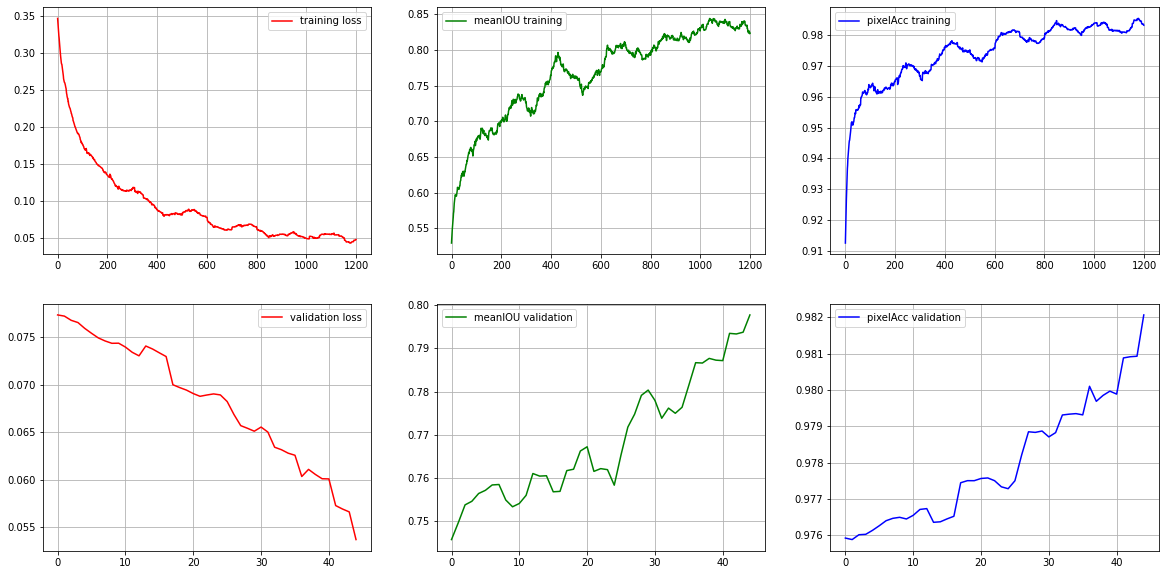

### Inference

In [ ]:
#can pass np array or path to image file
def SegmentHands(pathtest):


























    return mask

**Visualize the prediction mask.**

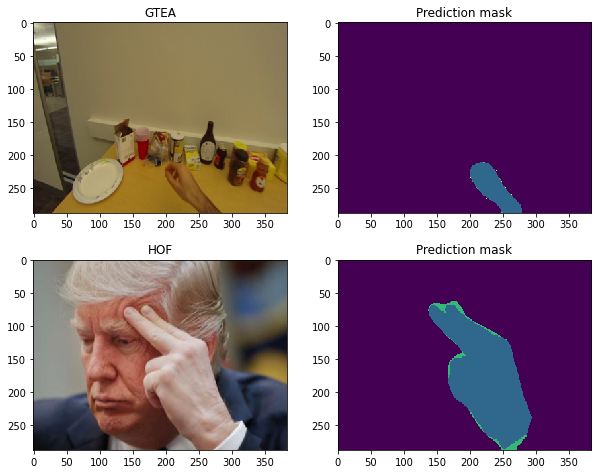